In [7]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import datetime
import time

In [8]:
start_time = time.time()
# Create a list that contains the URL for each page.
pages = []

# There are 155 pages in the entire set.
for page_number in range(1, 155):
    url_start = 'https://www.centralcharts.com/en/price-list-ranking/'
    url_end = 'ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p='
    url = url_start + url_end + str(page_number)
    pages.append(url)
    
##home page URL for reference:
# https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=1

In [9]:
#Create a list containing the <th> tag contents.
webpage = requests.get(pages[0])
soup = bs(webpage.text, 'html.parser')
stock_table = soup.find('table', class_='tabMini tabQuotes')
th_tag_list = stock_table.find_all('th')

In [10]:
# Take the <th> list and remove the extra attributes to
# get just the text portion of each tag. Use this text for the 
# column header labels in the dataframe.
headers = []
for each_tag in th_tag_list:
    title = each_tag.text
    headers.append(title)

headers[0] = 'Name'

new_headers = []
for header in headers:
    if header not in ('Cap.', 'Issued Cap.', ''):
        new_headers.append(header)
headers = new_headers
stock_df = pd.DataFrame(columns = headers)

In [11]:
# Iterate through each page. 
for page in pages:
    webpage = requests.get(page)
    soup = bs(webpage.text, 'html.parser')
    print(page)
    # Check to see if the page contains a table. If it does,
    # create a list of <tr> tags. If not, go to the next page.
    if soup.find('table'):
        stock_table = soup.find('table', class_='tabMini tabQuotes')
        tr_tag_list = stock_table.find_all('tr')

        # Cycle through the <tr> list. For each
        # row, find the <td> tags within the row. Then
        # obtain the text within each <td> tag. Lastly, 
        # place the text in the last row of the dataframe.
        for each_tr_tag in tr_tag_list[1:]:
            td_tag_list = each_tr_tag.find_all('td')

            row_values = []
            for each_td_tag in td_tag_list[0:7]:
                new_value = each_td_tag.text.strip()
                row_values.append(new_value)

            stock_df.loc[len(stock_df)] = row_values

https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=1
https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=2
https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=3
https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=4
https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=5
https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=6
https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=7
https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=8
https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-or

In [ ]:
# Change the data types & sort by trading volume
stock_df[['Name', 'Current price', 'Change(%)', 'Open','High', 'Low']] = \
    stock_df[['Name', 'Current price', 'Change(%)', 'Open', 'High', 'Low']] \
    .astype(str)

stock_df.replace({'Current price': {',':'', '-':'1'},
                  'Change(%)': {',':'', '-':'1', '%':''},
                  'Open': {',':'', '-':'1'},
                  'High': {',':'', '-':'1'},
                  'Low': {',':'', '-':'1'},
                  'Volume': {',':'', '-':'1'}
}, regex=True, inplace=True)

stock_df[['Current price', 'Change(%)', 'Open', 'High', 'Low', 'Volume']] = \
    stock_df[['Current price', 'Change(%)', 'Open', 'High', 'Low', 'Volume']]. \
    apply(pd.to_numeric)

stock_df = stock_df.sort_values(by=['Volume'], ascending=False)

print(stock_df)

# Export the dataframe to a csv file.
stock_df.to_csv('central_charts.csv', index=False)

C:\Users\peena\AppData\Local\Temp\ipykernel_8168\2735375160.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{x:,.0f}' for x in current_volumes], rotation=45)


--- 194.7145700454712 seconds ---


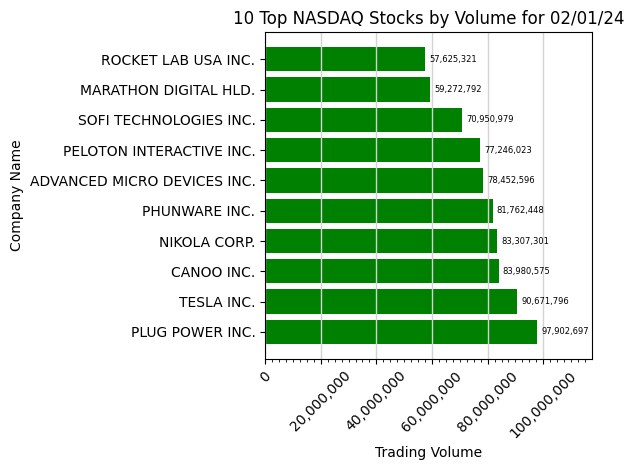

In [14]:
# Get the top 10 stocks and plot them on a horizontal bar chart
top_10_stock_df = stock_df.head(10)

# y-values
names = top_10_stock_df['Name']
# x-values
volumes = top_10_stock_df['Volume']

# Create the 'fig' object (the outermost section of the image
# that contains the axes object)
fig = plt.figure()

# Create the 'ax' object (found within the 'fig' object and
# contains the axes, labels, and the actual plot
ax = plt.subplot()

# Create the 'bar_plot' object, add the data and bar labels
bar_plot = ax.barh(names, volumes, color='green')
# Group each bar label in a 'container'. Format each data value with a
# comma every 3 digits.
container = ax.containers[0]
ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues],
    fontsize=6, padding=3)
current_volumes = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x:,.0f}' for x in current_volumes], rotation=45)

# Add a title and axis labels
ax.set_xlabel('Trading Volume')
ax.set_ylabel('Company Name')
now = datetime.now()
todays_date = now.strftime('%m/%d/%y')
ax.set_title('10 Top NASDAQ Stocks by Volume for ' + todays_date)

# Some formatting to give the labels proper padding
plt.tight_layout()
ax.set_xmargin(0.2)

# Add extra tick marks every 2.5 million
ax.xaxis.set_minor_locator(MultipleLocator(2500000))

# Add major gridlines
ax.grid(which='major', axis='x', color='lightgrey', linestyle='-', linewidth='1')

print("--- %s seconds ---" % (time.time() - start_time))

# Show the plot
plt.show()
